In [1]:
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Constants
N = 20
xMin = -2.0
xMax = 2.0
noizeScale = 0.5

w1 = 1.0
w2 = 0.5

random.seed(5)

w1Min = -3.0
w1Max = 3.0
w2Min = -3.0
w2Max  = 3.0
wStep = 0.05

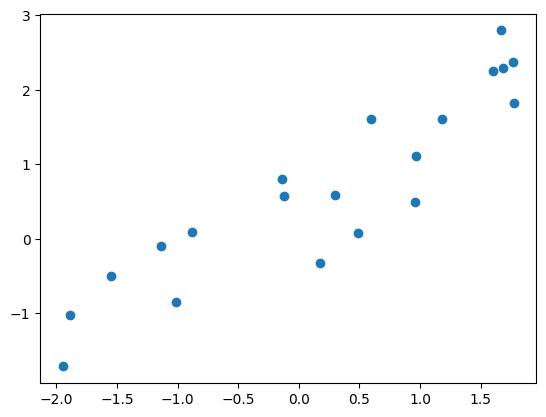

In [3]:
# make points
xs = np.array([(xMax - xMin) * random.random() + xMin for i in range(N)])
yTmps = (w1 * xs + w2)
noizes = np.random.normal(0, noizeScale, N)
ys = yTmps + noizes

plt.scatter(xs, ys)
plt.show()

In [4]:
# Error functions
def getDiff(xs, ys, ws):
    ones = np.ones(xs.size)
    
    xsArray = np.array([xs, ones])
    theoriticalVals = np.matmul(ws, xsArray)

    diffs = ys - theoriticalVals

    return diffs

def errorMSE(xs, ys, ws):
    diffs = getDiff(xs, ys, ws)

    mul = np.multiply(diffs, diffs)
    dot = np.sum(mul, axis = 2)

    return dot / xs.size

def errorMAE(xs, ys, ws):
    diffs = getDiff(xs, ys, ws)

    return np.sum(np.abs(diffs),axis=2) / xs.size

def errorME(xs, ys, ws):
    diffs = getDiff(xs, ys, ws)

    return np.max(np.abs(diffs), axis = 2)

"""
ws = [1.0, 0.5]
print(errorMSE(xs, ys, ws))
print(errorMAE(xs, ys, ws))
print(errorME(xs, ys, ws))
"""

'\nws = [1.0, 0.5]\nprint(errorMSE(xs, ys, ws))\nprint(errorMAE(xs, ys, ws))\nprint(errorME(xs, ys, ws))\n'

In [5]:
def displayError(xs, ys, errorFunc):
    w1s = np.arange(w1Min, w1Max, wStep)
    w2s = np.arange(w2Min, w2Max, wStep)

    W1, W2 = np.meshgrid(w1s, w2s)
    errors = errorFunc(xs, ys, np.array([W1, W2]).transpose(1, 2, 0))

    plt.pcolormesh(W1, W2, errors, cmap = 'prism')

    pp=plt.colorbar (orientation="vertical")

    plt.xlabel('w1', fontsize=10)
    plt.ylabel('w2', fontsize=10)


In [6]:
# Least squares methods
dataNum = xs.size

# (1.6)
xsArray = np.array(xs)
ysArray = np.array(ys)
xy = np.dot(xsArray, ysArray)
xSum = np.sum(xsArray)
ySum = np.sum(ysArray)
xdot = np.dot(xsArray, xsArray)
w1 = (dataNum * xy - xSum *ySum) / (dataNum * xdot - xSum**2)
# (1.7)
w2 = (ySum - w1 * xSum) / dataNum

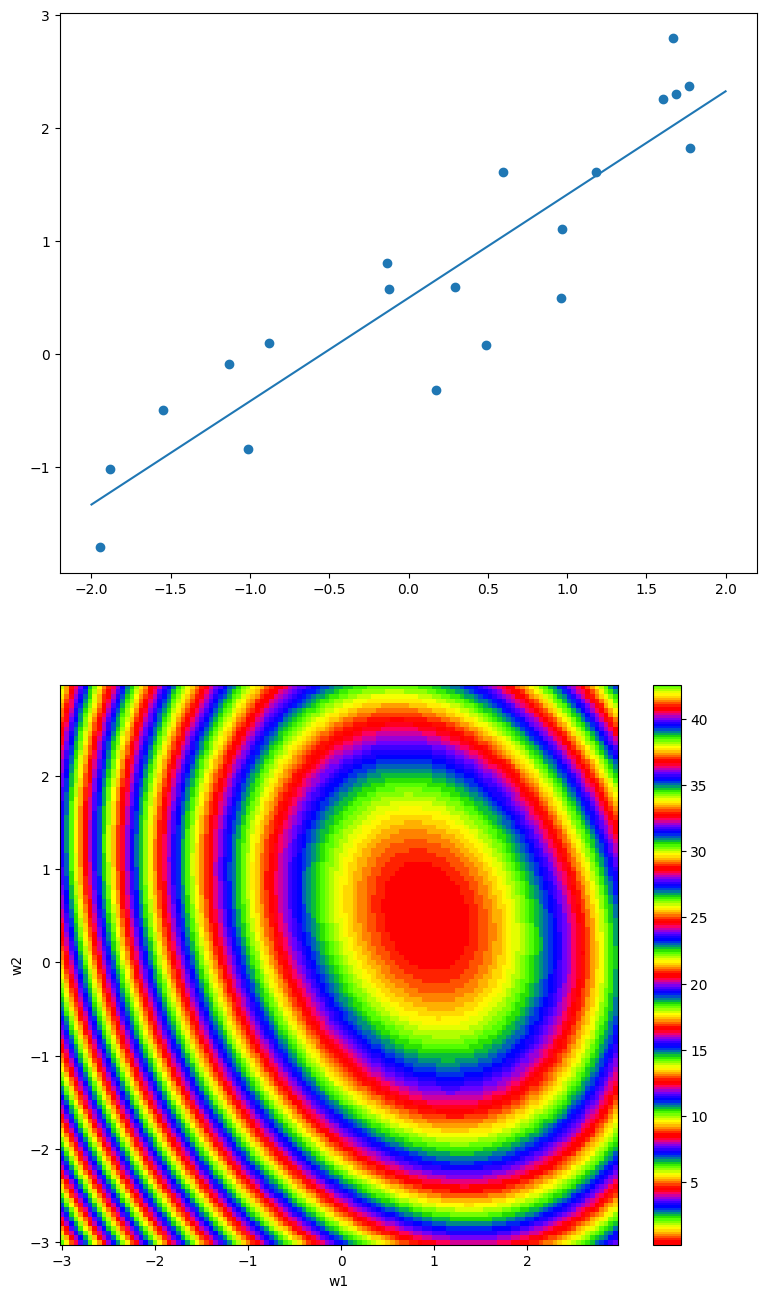

In [7]:
fig = plt.figure(figsize=(9,16))

plt.subplot(2,1,1)
plt.scatter(xs, ys)
plt.plot([xMin, xMax], [w1 * xMin + w2, w1 * xMax + w2])

plt.subplot(2,1,2)
displayError(xs, ys, errorMSE)


plt.show()

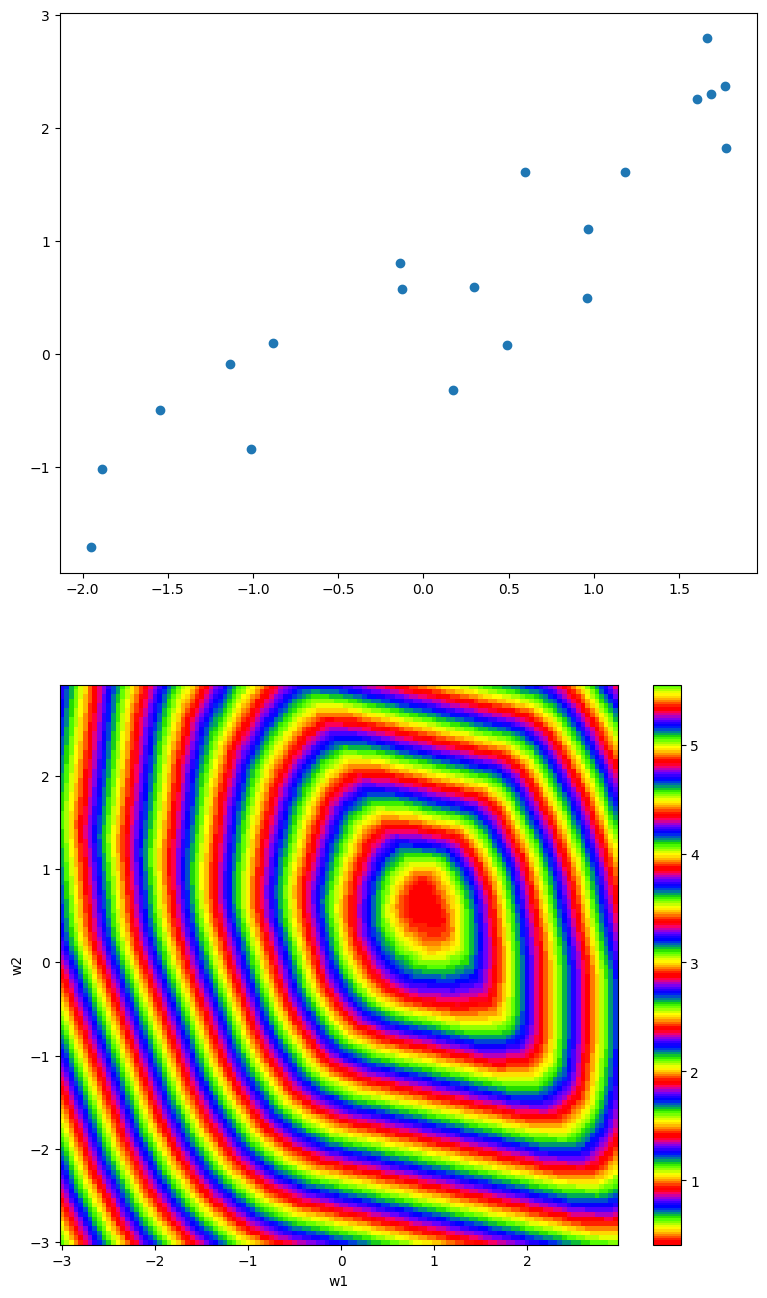

In [8]:
fig = plt.figure(figsize=(9,16))

plt.subplot(2,1,1)
plt.scatter(xs, ys)

plt.subplot(2,1,2)
displayError(xs, ys, errorMAE)

plt.show()

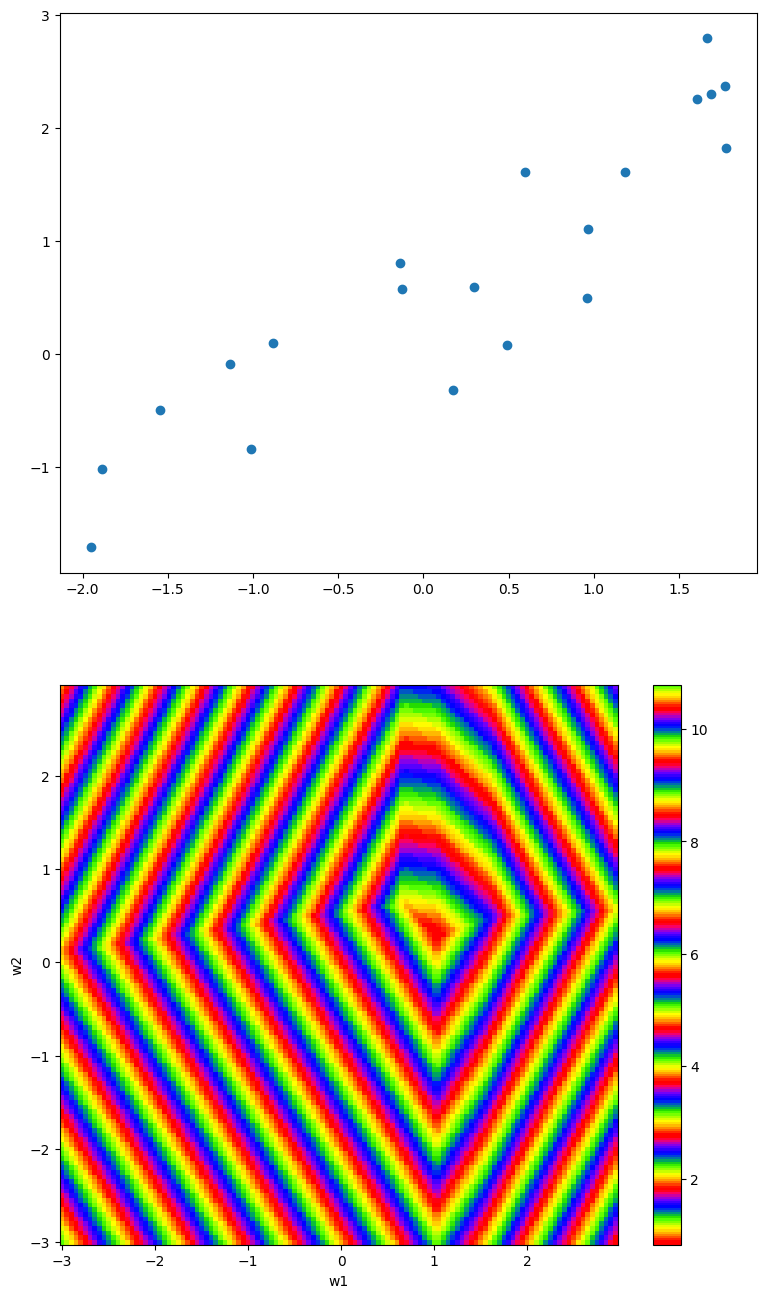

In [9]:
fig = plt.figure(figsize=(9,16))

plt.subplot(2,1,1)
plt.scatter(xs, ys)

plt.subplot(2,1,2)
displayError(xs, ys, errorME)

plt.show()

In [10]:
# Solve the optimization problem shown in (2.37)
# Object function : maximize x1 + 2 x2
# constraint :
#   x1 + x2 <= 6
#   x1 + 3 x2 <= 12
#   2 x1 + x2 <= 10
#   all variables (x1, x2) are positive

# Input values
# Variable names are defined refering section 2.2.4
c = [1, 2] # This is a row vector!!
N = [[1, 1], [1, 3], [2, 1]]
b = [6, 12, 10] # This is alse a row vector!!

# Here, c.size must be the same with N.shape[1]
# b.size must be the same with N.shape[0]
# They are not checked here. 

x1Min = -5.0
x1Max = 5.0
x2Min = -5.0
x2Max = 5.0
xStep = 0.05


In [11]:
def simplex(c, N, b):
    c = np.array(c)
    N = np.array(N)
    b = np.array(b)

    # Initialize
    B = np.eye(N.shape[0])
    c_n = np.array(c)
    c_b = np.zeros(N.shape[0])

    indexes = np.arange(np.sum(N.shape))
    xsList = []
    zList = []

    # Step 1
    x_b = np.matmul(np.linalg.inv(B), b)
    x_n = np.zeros(N.shape[1])
    
    while True:
        # Here is also Step 1
        bBar = np.matmul(np.linalg.inv(B), b)
        
        # Store the result
        # Here, x = 0 is feasible
        xsTmp = np.concatenate([x_n, x_b])
        xsBin = np.arange(indexes.size, dtype = float)
        for i in range(indexes.size):
            xsBin[indexes[i]] = xsTmp[i]
        z = np.dot(c, np.array(xsBin[:c.size]))

        xsList.append(xsBin)
        zList.append(z)

        # Step 2
        cnBar = c_n - np.dot(np.matmul(np.transpose(N), np.transpose(np.linalg.inv(B))), c_b)

        # Step 3
        if np.max(cnBar) <= 0:
            break
        
        k = np.argmax(cnBar)

        # Step 4
        NBar = np.matmul(np.linalg.inv(B), N)
        aBar = NBar[:,k]

        if np.max(aBar) <= 0:
            zList.append(np.Inf)

        thetaArg = 0
        theta = np.Inf
        for i in range(bBar.size):
            if aBar[i] > 0:
                if (bBar[i] / aBar[i] < theta):
                    thetaArg = i
                    theta = bBar[i] / aBar[i]

        # Step 5
        x_b = bBar - theta * aBar
        x_b[thetaArg] = theta
        for i in range(N.shape[0]):
            tmp = N[i][k]
            N[i][k] = B[i][thetaArg]
            B[i][thetaArg] = tmp

        tmp = c_n[k]
        c_n[k] = c_b[thetaArg]
        c_b[thetaArg] = tmp

        tmp = indexes[k]
        indexes[k] = indexes[N.shape[1] + thetaArg]
        indexes[N.shape[1] + thetaArg] = tmp

    return zList, xsList


[0.0, 8.0, 9.0]
[array([ 0.,  0.,  6., 12., 10.]), array([0., 4., 2., 0., 6.]), array([3., 3., 0., 0., 1.])]


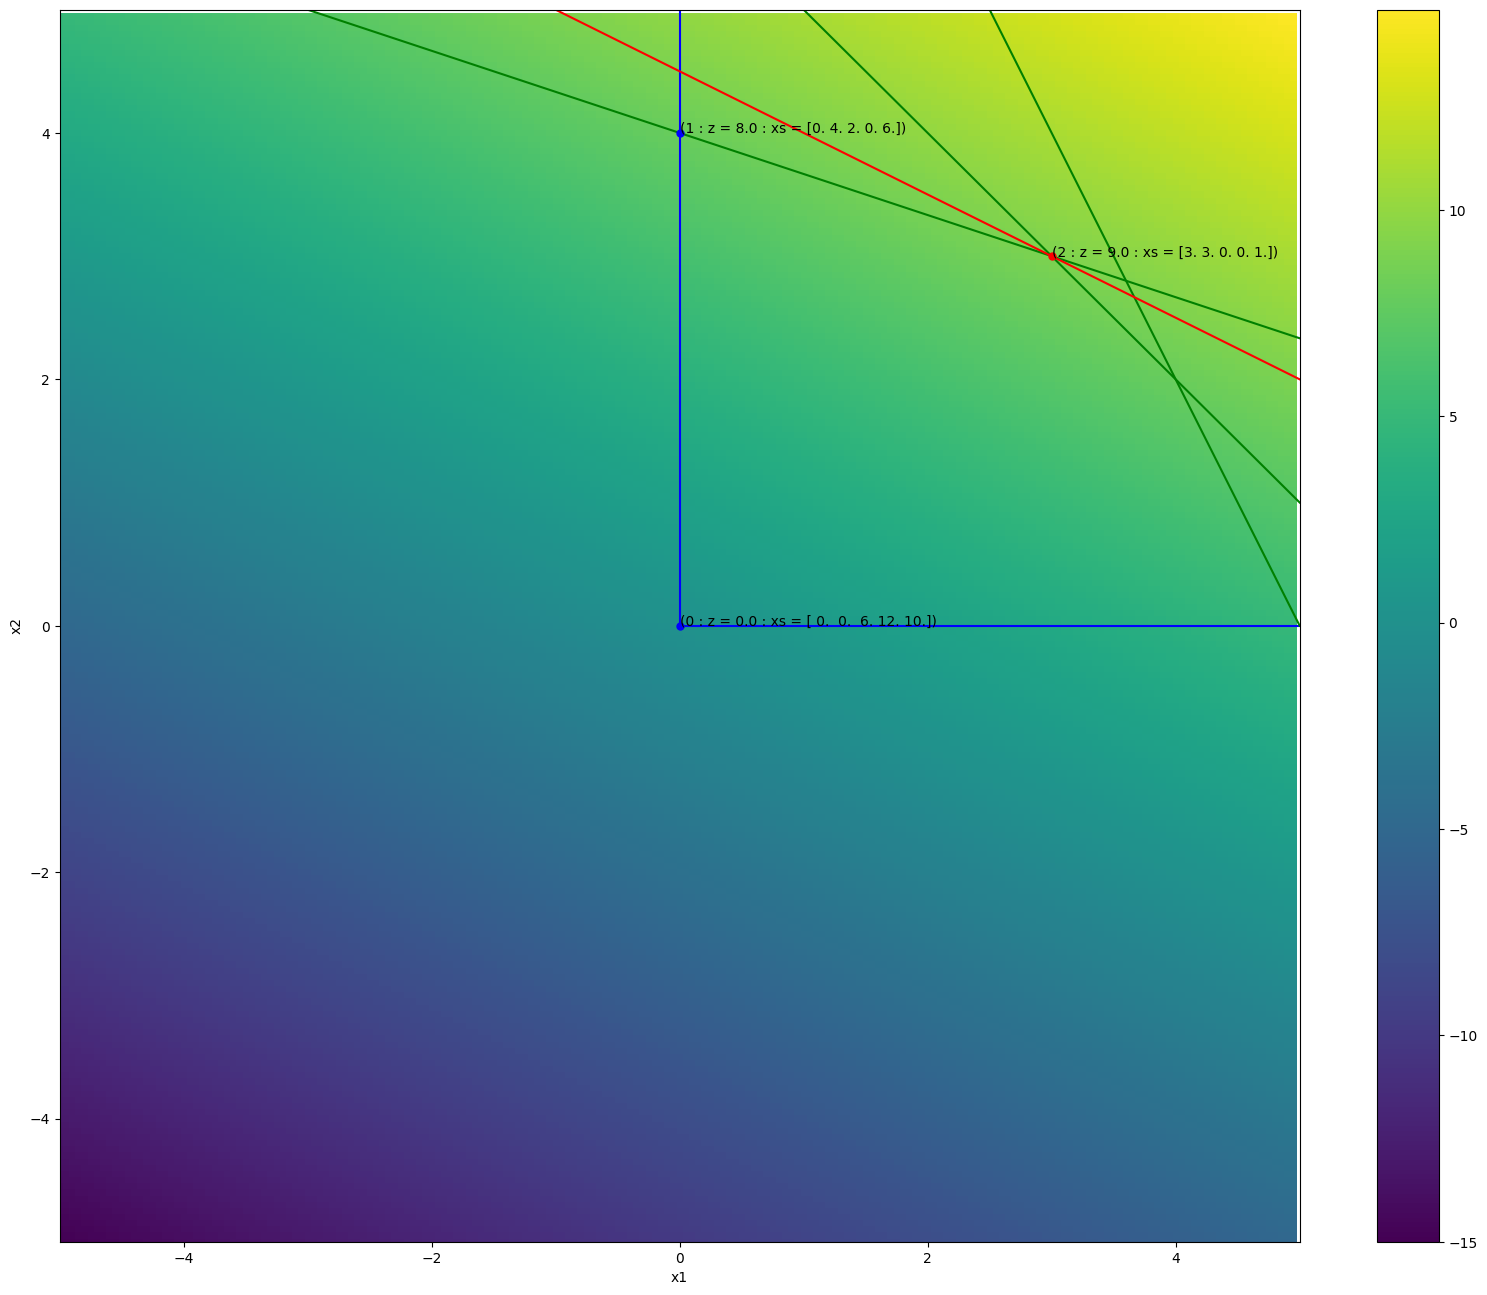

In [12]:
zList, xsList = simplex(c, N, b)
print(zList)
print(xsList)

x1s = np.arange(x1Min, x1Max, xStep)
x2s = np.arange(x2Min, x2Max, xStep)

X1, X2 = np.meshgrid(x1s, x2s)
zs = np.dot(np.array([X1, X2]).transpose(1, 2, 0), c)

fig = plt.figure(figsize=(20,16))
plt.pcolormesh(X1, X2, zs)

pp=plt.colorbar (orientation="vertical")

plt.xlabel('x1', fontsize=10)
plt.ylabel('x2', fontsize=10)

plt.plot([0, x1Max], [0, 0], color = "b")
plt.plot([0, 0], [0, x2Max], color = "b")
plt.xlim([x1Min, x1Max])
plt.ylim([x2Min, x2Max])

for n, bElem in zip(N, b):
    a1 = - n[0] / n[1]
    a2 = bElem / n[1]
    x1Points = np.array([x1Min, x1Max])
    plt.plot(x1Points, a1 * x1Points + a2, color = "g")

plt.plot(xsList[-1][0], xsList[-1][1], marker='.', markersize = 10, color = "r")
plt.text(xsList[-1][0], xsList[-1][1], "({} : z = {} : xs = {})".format(len(zList) - 1, zList[-1], xsList[-1]), size = 10)
plt.plot(x1Points, -c[0] / c[1] * x1Points + zList[-1] / c[1], color = "r")

for i in range(len(zList) - 1):
    plt.plot(xsList[i][0], xsList[i][1], marker='.', markersize = 10, color = "b")
    plt.text(xsList[i][0], xsList[i][1], "({} : z = {} : xs = {})".format(i, zList[i], xsList[i]), size = 10)

plt.show()
